In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [23]:
spectrum_primary = pd.read_csv("spectrum_primary.csv",index_col=None,delim_whitespace=True)
spectrum_primary.head()

,wave,flux,normed_flux
0,3000.0033,0.000226,0.719871
1,3000.0083,0.000295,0.939125
2,3000.0133,0.000297,0.945691
3,3000.0183,0.000287,0.912834
4,3000.0233,0.000272,0.866837


In [24]:
spectrum_secondary = pd.read_csv("spectrum_primary.csv",index_col=None,delim_whitespace=True)
spectrum_secondary.head()

,wave,flux,normed_flux
0,3000.0033,0.000226,0.719871
1,3000.0083,0.000295,0.939125
2,3000.0133,0.000297,0.945691
3,3000.0183,0.000287,0.912834
4,3000.0233,0.000272,0.866837


In [25]:
spectrum_primary = {k:v.values for k,v in spectrum_primary.items()}
spectrum_primary["wave"] = np.log10(spectrum_primary["wave"])
spectrum_secondary = {k:v.values for k,v in spectrum_secondary.items()}
spectrum_secondary["wave"] = np.log10(spectrum_secondary["wave"])

In [26]:
NO_FLUX_POINTS = spectrum_primary["wave"].shape[0]

### Train NN model

In [27]:
import jax
from jax import lax, random, numpy as jnp
import flax
# from flax.core import freeze, unfreeze
from flax import linen as nn

from flax.training import train_state, checkpoints  # Useful dataclass to keep train state
# import numpy as np                                # Ordinary NumPy
import optax                                        # Optimizers

In [28]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


In [29]:
def frequency_encoding(x, min_period, max_period, dimension):
    periods = jnp.logspace(jnp.log10(min_period), jnp.log10(max_period), num=dimension)
    
    y = jnp.sin(2*jnp.pi/periods*x)
    return y

class MLP_single_wavelength_sine(nn.Module):
    architecture: tuple = (256, 256, 256, 256)
    @nn.compact
    def __call__(self, x):
        w = x
        enc_w = frequency_encoding(w, min_period=1e-5, max_period=1.0, dimension=128)
        _x = enc_w
        for features in self.architecture:
            _x = nn.relu(nn.Dense(features)(_x))
        x = nn.Dense(1, bias_init=nn.initializers.ones)(_x)
        return x
    
class MLP_wavelength_sine(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        log_waves = inputs
        
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_sine, 
                    in_axes=0, out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")(log_waves)
        x = x[...,0]
        return x

In [41]:
TRAINING_STEPS    = 100000
WARM_UP_STEPS     = 10000
LEARNING_RATE     = 1e-3
NO_SAMPLES        = int(2**16)#37549#int(2**15)
CHECKPOINTS_DIR   = 'ckpts'

In [42]:
def mse_loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)

def mae_loss(y_pred, y_true):
    return jnp.mean(jnp.abs(y_pred - y_true))

def quantile_absolute_error(y_pred, y_true, q=0.95):
    return jnp.quantile(jnp.abs(y_pred - y_true), q=q)

def maximum_absolute_error(y_pred, y_true):
    return jnp.max(jnp.abs(y_pred - y_true))

def mare_loss(y_pred, y_true):
    return jnp.mean(jnp.abs((y_pred - y_true)/y_true))

# average of worst q*100 percent fluxes
def quantile_mean_absolute_error(y_pred, y_true, q=0.95):
    abs_error = jnp.abs(y_pred - y_true)
    v = jnp.quantile(abs_error, q=q)
    return jnp.mean(abs_error, where=(abs_error>v))

In [43]:
def compute_metrics(*, y_pred, y_true):
    loss = mse_loss(y_pred, y_true)
    mae = mae_loss(y_pred, y_true)
    qae090 = quantile_absolute_error(y_pred, y_true, q=0.95)
    max_ae = maximum_absolute_error(y_pred, y_true)
    mare = mare_loss(y_pred, y_true)
    m95_per = quantile_mean_absolute_error(y_pred, y_true, q=0.95)
    metrics = {
      'loss': loss,
      'mae': mae,
      '95_per': qae090,
      'max_ae': max_ae,
      'mare': mare,
      'm95_per': m95_per,
    }
    return metrics

def create_train_state(rng, model):
    """Creates initial `TrainState`."""
    m = model()
    dummpy_input = jnp.ones(NO_SAMPLES)
    params = m.init(rng, dummpy_input, False)['params']
    
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE,
        warmup_steps=WARM_UP_STEPS,
        decay_steps=TRAINING_STEPS-WARM_UP_STEPS,
        end_value=0.0,
    )
    tx = optax.adam(learning_rate=schedule)

    return train_state.TrainState.create(apply_fn=m.apply, params=params, tx=tx)


@jax.jit
def train_step(state, batch, rngs):
    """Train for a single step."""
    # Make sure to get a new RNG at every step.
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}
    
    def loss_fn(params):
        y_pred = state.apply_fn({'params': params}, 
                                   batch["input"],
                                   train = True,
                                   rngs=rngs)
        loss = mse_loss(y_pred=y_pred, y_true=batch["normed_flux"])
        return loss, y_pred
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_,y_pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = compute_metrics(y_pred=y_pred, y_true=batch['normed_flux'])
    
    return state, metrics

@jax.jit
def eval_step(state, batch):
    y_pred = state.apply_fn({'params': state.params},
                        batch["input"], 
                        train=False
                        )
    metrics = compute_metrics(y_pred=y_pred, y_true=batch['normed_flux'])
    return metrics

<IPython.core.display.Javascript object>


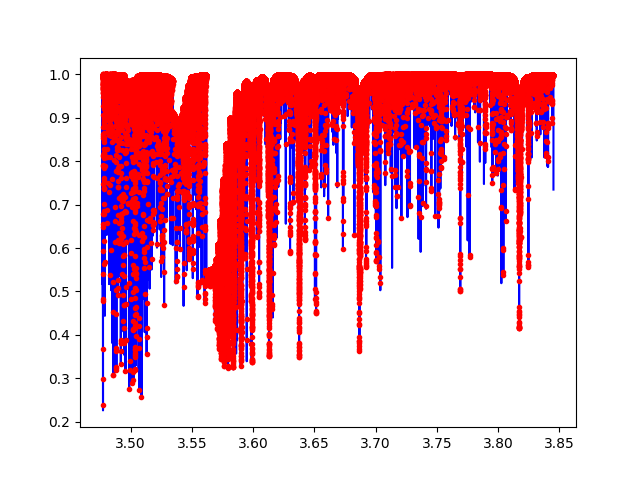

In [44]:
def sample_from_example(wave: np.array, flux: np.array, no_samples:int):
    min_wave = wave[0]
    max_wave = wave[-1]
    
    sampled_wave = np.random.uniform(min_wave, max_wave, size=no_samples)
    
    return sampled_wave, np.interp(sampled_wave, wave, flux)

idx = 1
log_wave = spectrum_primary["wave"]
flux = spectrum_primary["normed_flux"]
sw, sf = sample_from_example(wave=log_wave,
                         flux=flux, 
                         no_samples=NO_SAMPLES
                        )

plt.figure()
plt.plot(log_wave, flux,'b')
plt.plot(sw, sf,'r.')

In [45]:
def get_batch(rng, example):
    while True:
        log_wave = example["wave"]
        flux = example["normed_flux"]
        sw, sf = sample_from_example(wave=log_wave,
                                 flux=flux, 
                                 no_samples=NO_FLUX_POINTS
                                )
        
        yield {"input":sw,"normed_flux":sf}

In [46]:
def train(state, 
          rngs, 
          train_ds,
          model_name = "MLP_sine",
          no_steps_stats = 100):
    
    full_training_metrics = []
    train_metrics = []

    for step_number, batch in enumerate(get_batch(rng,train_ds)):

        # Training step:
        state, metrics = train_step(state, batch, rngs)
        train_metrics.append(metrics)

        if state.step % no_steps_stats == 1: # Summarize after each no_steps_stats steps

            # compute mean of metrics across last no_steps_stats steps
            train_summary = jax.device_get(train_metrics)
            train_metrics = []
            train_summary = {
                      k: np.mean([metrics[k] for metrics in train_summary])
                      for k in train_summary[0]}

            # Gather metrics
            full_training_metrics.append(train_summary)

            print(f'TRAINING   step: {step_number:6d}, ' + ", ".join([f"{k} = {v:.6f}" for k,v in train_summary.items()]))

        if state.step > TRAINING_STEPS:
            print("FINISH TRAINING: state.step >= TRAINING_STEPS")
            prefix = f"checkpoint_{model_name}_"
            checkpoints.save_checkpoint(ckpt_dir=CHECKPOINTS_DIR, 
                                        target=state,
                                        overwrite=True,
                                        prefix=prefix,
                                        step=step_number)


            df_train_summary = pd.DataFrame(full_training_metrics)
   

            break
    return state, df_train_summary

In [48]:
model = MLP_wavelength_sine
model_name = "MLP_sine"
# model = MLP_wavelength_sirens
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

state = create_train_state(init_rng, model)
del init_rng

# run training
train_ds = spectrum_primary
state, df_train_summary = train(state, 
                                 rngs, 
                                 train_ds,
                                 model_name = model_name,
                                 no_steps_stats = 1000)

TRAINING   step:      0, 95_per = 0.317474, loss = 0.022327, m95_per = 0.424917, mae = 0.109361, mare = 0.135864, max_ae = 0.836013
TRAINING   step:   1000, 95_per = 0.122654, loss = 0.005344, m95_per = 0.193683, mae = 0.044186, mare = 0.054118, max_ae = 0.701025
TRAINING   step:   2000, 95_per = 0.036518, loss = 0.000501, m95_per = 0.063828, mae = 0.013850, mare = 0.015935, max_ae = 0.405425
TRAINING   step:   3000, 95_per = 0.020519, loss = 0.000136, m95_per = 0.031204, mae = 0.008175, mare = 0.009091, max_ae = 0.191024
TRAINING   step:   4000, 95_per = 0.013729, loss = 0.000060, m95_per = 0.018856, mae = 0.005697, mare = 0.006326, max_ae = 0.144902
TRAINING   step:   5000, 95_per = 0.010614, loss = 0.000037, m95_per = 0.013838, mae = 0.004558, mare = 0.005111, max_ae = 0.131685
TRAINING   step:   6000, 95_per = 0.008728, loss = 0.000028, m95_per = 0.011229, mae = 0.003803, mare = 0.004292, max_ae = 0.126263
TRAINING   step:   7000, 95_per = 0.007763, loss = 0.000022, m95_per = 0.009

TRAINING   step:  63000, 95_per = 0.000870, loss = 0.000000, m95_per = 0.001665, mae = 0.000317, mare = 0.000372, max_ae = 0.037234
TRAINING   step:  64000, 95_per = 0.000840, loss = 0.000000, m95_per = 0.001630, mae = 0.000307, mare = 0.000360, max_ae = 0.038999
TRAINING   step:  65000, 95_per = 0.000819, loss = 0.000000, m95_per = 0.001604, mae = 0.000301, mare = 0.000352, max_ae = 0.039112
TRAINING   step:  66000, 95_per = 0.000796, loss = 0.000000, m95_per = 0.001578, mae = 0.000293, mare = 0.000343, max_ae = 0.038775
TRAINING   step:  67000, 95_per = 0.000772, loss = 0.000000, m95_per = 0.001551, mae = 0.000285, mare = 0.000333, max_ae = 0.036383
TRAINING   step:  68000, 95_per = 0.000754, loss = 0.000000, m95_per = 0.001529, mae = 0.000280, mare = 0.000326, max_ae = 0.037391
TRAINING   step:  69000, 95_per = 0.000732, loss = 0.000000, m95_per = 0.001507, mae = 0.000273, mare = 0.000317, max_ae = 0.037096
TRAINING   step:  70000, 95_per = 0.000716, loss = 0.000000, m95_per = 0.001

<IPython.core.display.Javascript object>


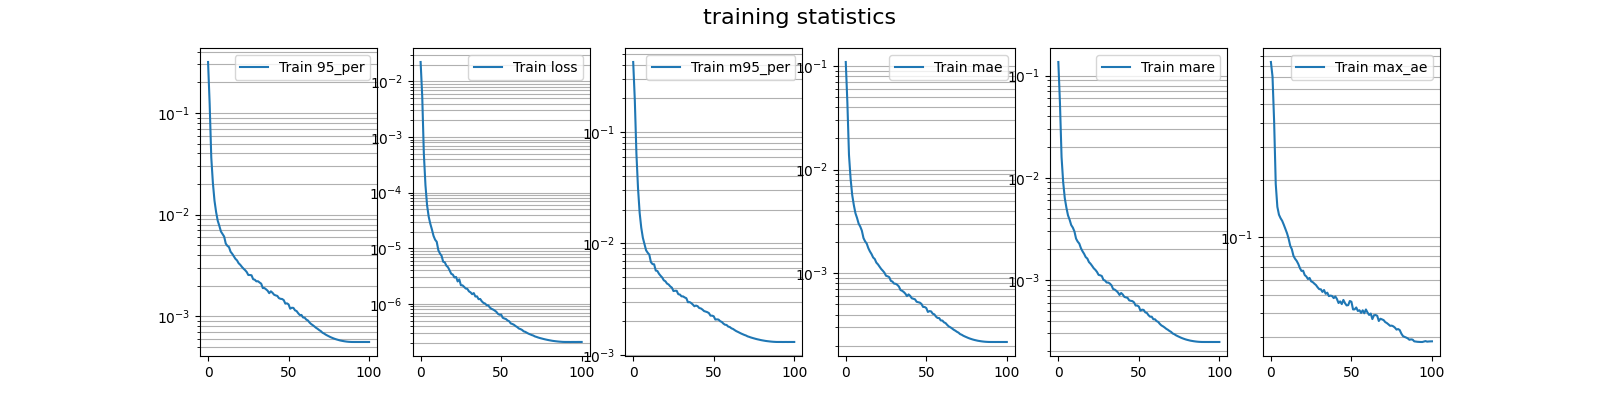

In [49]:
# Plot
ncols= df_train_summary.shape[1]
fig, axs = plt.subplots(ncols=ncols, figsize=(16,4))
fig.suptitle(f"training statistics", fontsize=16)
for i, c in enumerate(df_train_summary.columns):
    axs[i].semilogy(df_train_summary[c],label=f"Train {c}")
    axs[i].legend()
    axs[i].grid(which="both", axis='y')

In [50]:
prefix = f"checkpoint_{model_name}_"
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINTS_DIR, target=state, prefix=prefix)
if state is restored_state:
    raise FileNotFoundError(f"Cannot load checkpoint from {CHECKPOINTS_DIR}")

In [51]:
@jax.jit
def predict(state, batch):
    y_pred = state.apply_fn({'params': state.params}, 
                        batch["input"], 
                        train=False
                       )
    return compute_metrics(y_pred=y_pred, y_true=batch['normed_flux']), y_pred


spec = spectrum_primary
log_wave = spec["wave"]
exact_flux = spec["normed_flux"]
batch = {"input":log_wave,"normed_flux":exact_flux}
metrics, predicted_normed_flux = predict(restored_state, batch)
metrics

{'95_per': DeviceArray(0.00056869, dtype=float32),
 'loss': DeviceArray(2.1685673e-07, dtype=float32),
 'm95_per': DeviceArray(0.00132529, dtype=float32),
 'mae': DeviceArray(0.00021916, dtype=float32),
 'mare': DeviceArray(0.00025001, dtype=float32),
 'max_ae': DeviceArray(0.04084057, dtype=float32)}

<IPython.core.display.Javascript object>


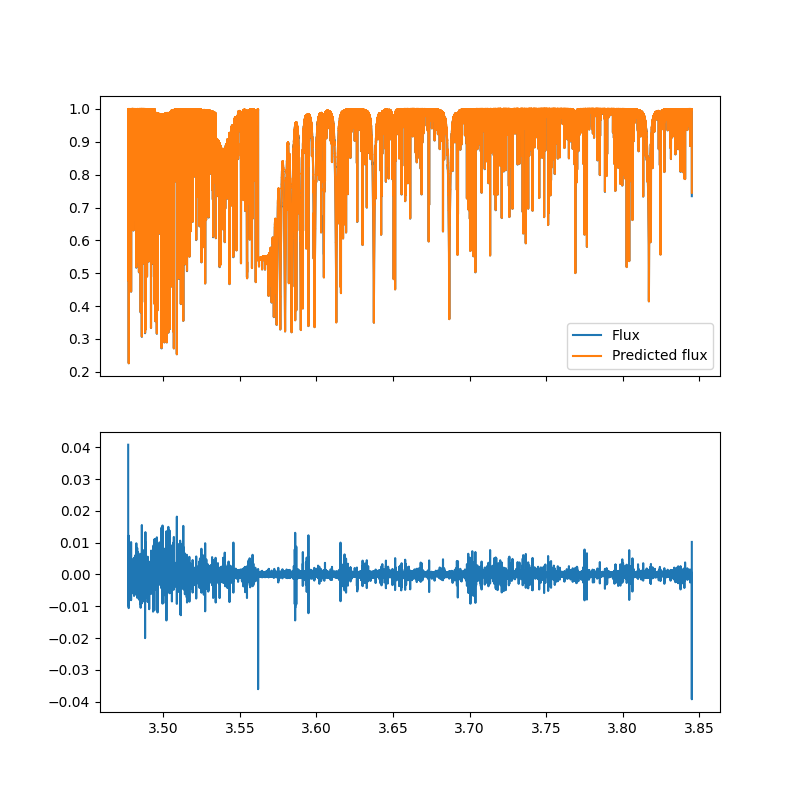

2.168567334592808e-07, 0.00021915791148785502, 0.000568687915802002


In [52]:
fig, axs = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

axs[0].plot(log_wave, exact_flux,label="Flux")
axs[0].plot(log_wave, predicted_normed_flux,label="Predicted flux")
axs[0].legend()

axs[1].plot(log_wave, (predicted_normed_flux-exact_flux))

mse = mse_loss(predicted_normed_flux,exact_flux)
mae = mae_loss(predicted_normed_flux,exact_flux)
per = quantile_absolute_error(predicted_normed_flux,exact_flux,q=0.95)
print(f"{mse}, {mae}, {per}")